# Define Extended Droughts and Pluvials using SM-REC Soil Moisture Reconstruction

### Start Clean

In [1]:
# Reset the environment (start clean)
%reset -f

# Import Modules and define functions
import calendar
import datetime
import os
import numpy as np
import numpy.ma as ma
import netCDF4
import matplotlib
import copy
from matplotlib import pyplot as plt
import scipy
import scipy.signal
import scipy.io as sio
import seaborn as sns
import pandas as pd
import scipy.stats as stats
#import statsmodels.api as sm
from IPython.display import display
import IPython
import requests
import pandas as pd
import os
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf 
import matplotlib.colors as colors

# cartopy stuff
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry.polygon import LinearRing
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Borders for mapping: Cultural borders
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
# Coastline
newcoast = cfeature.NaturalEarthFeature('physical', 'coastline', '10m',
                                        edgecolor='k',
                                        facecolor='none')
#Lakes
newlake = cfeature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='k',
                                        facecolor='none')

# Embeds plots inside the notebook (use in iPython Notebook)
%matplotlib inline

# For asymetric colorbars
# https://matplotlib.org/stable/tutorials/colors/colormapnorms.html?highlight=twoslopenorm#twoslopenorm-different-mapping-on-either-side-of-a-center
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# For plotting a rectangle on the maps
def plot_rectangle(ax, lonmin,lonmax,latmin,latmax):
    xs = [lonmin,lonmax,lonmax,lonmin,lonmin]
    ys = [latmin,latmin,latmax,latmax,latmin]
    #ax.plot(xs, ys,latlon = True, color='k', linestyle='--', linewidth=3)
    ax.plot(xs,ys,color='k',linestyle='--',linewidth=3,transform=ccrs.PlateCarree())

# For plotting a point on a map
def plot_point(ax,lon,lat):
    xs = [lon]
    ys = [lat]
    #ax.plot(xs, ys,latlon = True, color='k', linestyle='--', linewidth=3)
    #ax.scatter(xs,ys,color=np.array([0.5,0.5,0.5]),marker='*',linewidth=3,transform=ccrs.PlateCarree())
    ax.scatter(xs,ys,color='k',edgecolors='k',marker='+',linewidth=0.5,s=5,transform=ccrs.PlateCarree(),zorder=2,alpha=0.5)

ocean_color = np.float64([209,230,241])/255
nmap=plt.get_cmap(name=plt.cm.BrBG,lut=12) # only needed to set bins for pcolor/pcolormesh
      
# Month Vector
mons     = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

# Set plot styles
# Formatting for titles
fontdict_title = {'fontsize': 36}
fig_size = np.array([10,10])

# Formatting for figures
style_new = {'xtick.direction': 'in', \
             'ytick.direction': 'in', \
             'font.sans-serif': 'Arial'}


## Function for Finding Consecutive Values

In [2]:
def group_consecutives(vals, step=1):
    """Return list of consecutive lists of numbers from vals (number list)."""
    run = []
    result = [run]
    expect = None
    for v in vals:
        if (v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    return result


## Process Running Means and Plot SM-REC

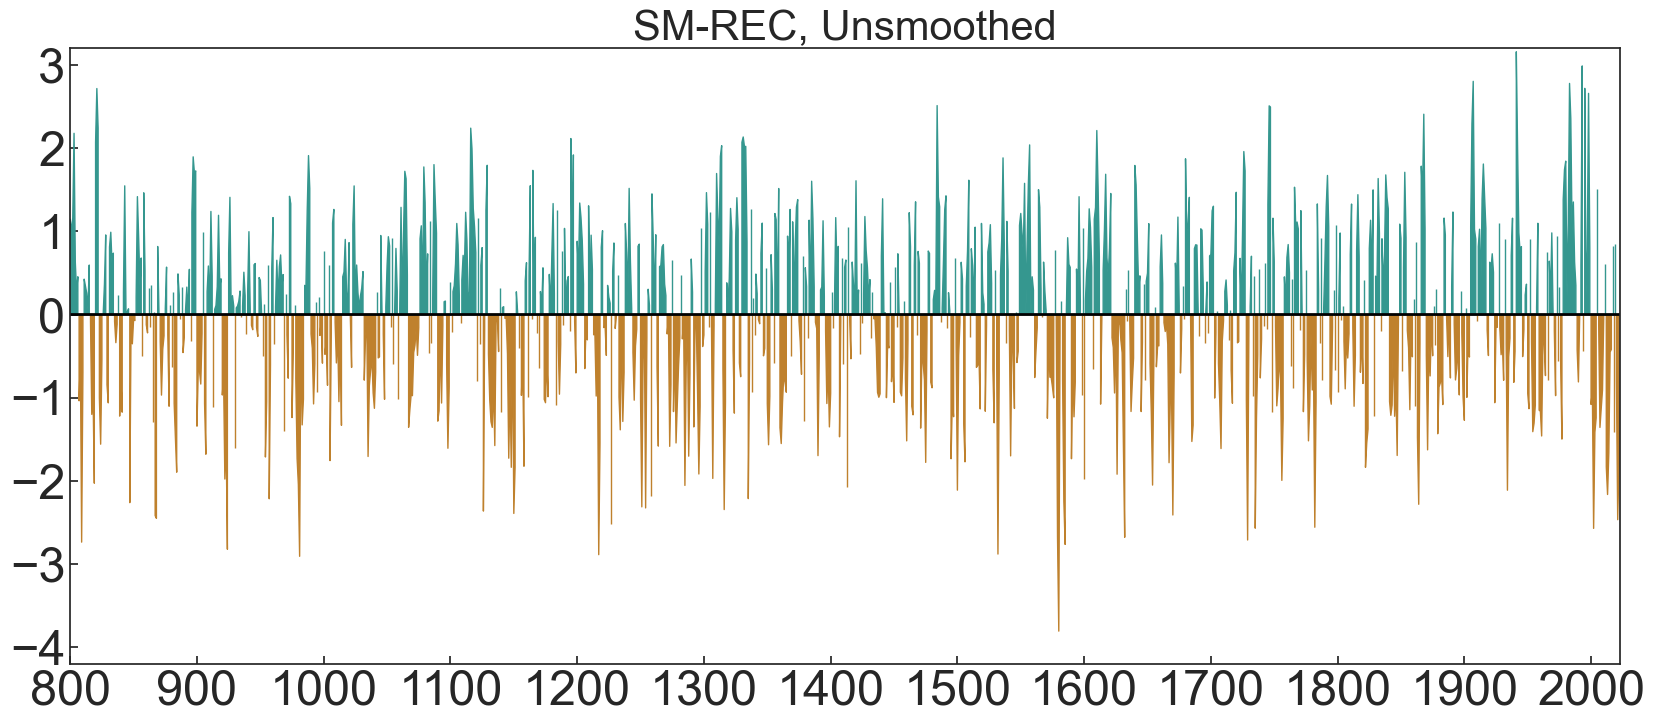

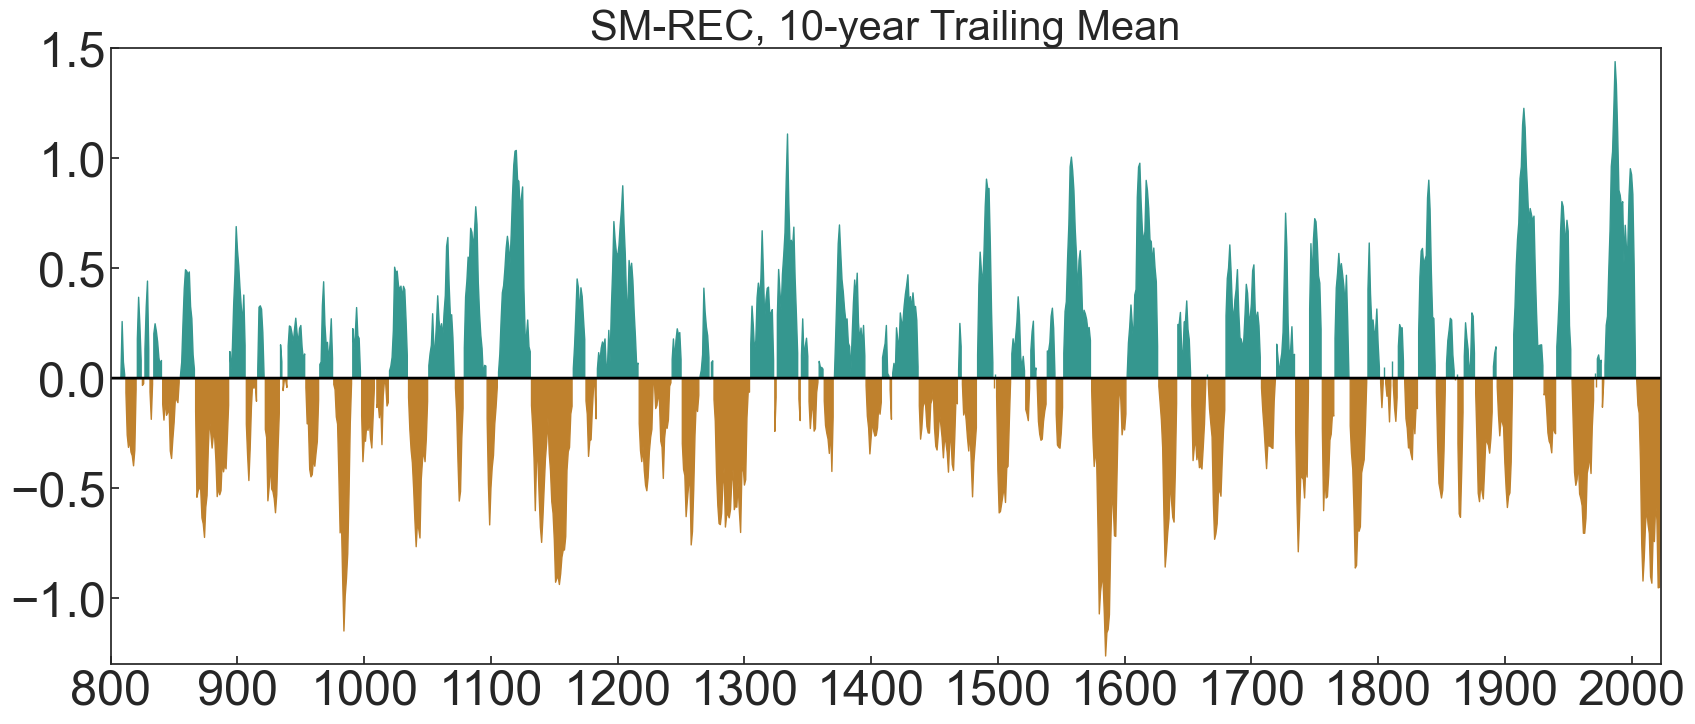

In [3]:
# Load into dataframe
pd_SMseries = pd.read_csv('../data/smrec/recon_2023.txt',delimiter=',')

# Pull out bias-corrected reconustruction and observational time series
sm_obs_yr = np.array(pd_SMseries['year'][:])
sm_obs_all = np.array(pd_SMseries['recon'][:])

# For zero line
y_zeros = np.zeros(sm_obs_yr.shape)

# Create Rolling Means of soil moisture
sm_5yr  = np.array(pd.Series(sm_obs_all).rolling(5).mean())
sm_10yr = np.array(pd.Series(sm_obs_all).rolling(10).mean())

# Replace NaN with zero values (only in the beginning, before the full moving averages can start)
# base data
i_miss5yr  = np.where(np.isnan(sm_5yr)==True)[0];   sm_5yr[i_miss5yr]   = 0;
i_miss10yr = np.where(np.isnan(sm_10yr)==True)[0];  sm_10yr[i_miss10yr] = 0

# Figure: unsmoothed
currplot=plt.figure(figsize=(20,8),facecolor="white")
sns.set_style("ticks",style_new)
sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 1.5})
#plt.fill_between(np.arange(2000,2020+1), -5, 4,color=[0.8,0.8,0.8], alpha=0.5,zorder=0)
plt.plot(sm_obs_yr,y_zeros,'-', color='k', linewidth=2)
#plt.plot(sm_obs_yr,sm_obs_all,color='k',linewidth=1)
# Shading
i_neg=sm_obs_all.copy(); i_neg[np.where(i_neg>=0)]=0; i_neg[np.where(i_neg<0)]=1
i_pos=sm_obs_all.copy(); i_pos[np.where(i_neg==0)]=1; i_pos[np.where(i_neg==1)]=0
plt.fill_between(sm_obs_yr, y_zeros, sm_obs_all, where=i_neg, color='#bf812d', alpha=1)
plt.fill_between(sm_obs_yr, y_zeros, sm_obs_all, where=i_pos, color='#35978f', alpha=1)
plt.yticks([-4,-3,-2,-1,0,1,2,3,4],fontsize=35)
plt.xticks([800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000],fontsize=35)
plt.xlim(800,2023)
plt.ylim(-4.2,3.2)
plt.title('SM-REC, Unsmoothed')
plt.savefig('../figures/sm200_recon_1yr_update_2023.pdf',format='pdf')
display(currplot)

# Figure: 10-year smoothed version
currplot=plt.figure(figsize=(20,8),facecolor="white")
sns.set_style("ticks",style_new)
sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 1.5})
#plt.fill_between(np.arange(2000,2020+1), -5, 4,color=[0.8,0.8,0.8], alpha=0.5,zorder=0)
plt.plot(sm_obs_yr,y_zeros,'-', color='k', linewidth=2)
#plt.plot(sm_obs_yr,sm_obs_all,color='k',linewidth=1)
# Shading
i_neg=sm_10yr.copy(); i_neg[np.where(i_neg>=0)]=0; i_neg[np.where(i_neg<0)]=1
i_pos=sm_10yr.copy(); i_pos[np.where(i_neg==0)]=1; i_pos[np.where(i_neg==1)]=0
plt.fill_between(sm_obs_yr, y_zeros, sm_10yr, where=i_neg, color='#bf812d', alpha=1)
plt.fill_between(sm_obs_yr, y_zeros, sm_10yr, where=i_pos, color='#35978f', alpha=1)
plt.yticks([-1.0,-0.5,0,0.5,1.0,1.5],fontsize=35)
plt.xticks([800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000],fontsize=35)
plt.xlim(800,2023)
plt.ylim(-1.3,1.5)
plt.title('SM-REC, 10-year Trailing Mean')
plt.savefig('../figures/sm200_recon_10yr_update_2023.pdf',format='pdf')
display(currplot)

# Close all plot instances
plt.close('all')


## Find Consecutive 5 year drought periods

In [4]:
# Indices for drought and pluvial years
i_drght = np.where(sm_obs_all<0)[0]

# Create list of contiguous drought/pluvial years
contig_drght_yrs = group_consecutives(i_drght, step=1)

# Initialize array for 5 year drought stats (first year, last year, length, cumsev)
drought_stats_cont5yr = np.zeros((len(contig_drght_yrs),6))*np.nan

# Loop through each drought event
for n_drght in np.arange(0,len(contig_drght_yrs)):
    
    # Current drought indices
    i_curr_drght = contig_drght_yrs[n_drght].copy()
    
    # Years and values for current event
    yrs_curr_drght  = sm_obs_yr[i_curr_drght].copy()
    vals_curr_drght = sm_obs_all[i_curr_drght].copy()
    
    # Store drought stats
    drought_stats_cont5yr[n_drght,0] = np.min(yrs_curr_drght)
    drought_stats_cont5yr[n_drght,1] = np.max(yrs_curr_drght)
    drought_stats_cont5yr[n_drght,2] = np.size(yrs_curr_drght)
    drought_stats_cont5yr[n_drght,3] = np.where(vals_curr_drght>=0)[0].size
    drought_stats_cont5yr[n_drght,4] = np.mean(vals_curr_drght)
    drought_stats_cont5yr[n_drght,5] = np.sum(vals_curr_drght)

# Trim to just events with at least five years
i_5yr                    = np.where(drought_stats_cont5yr[:,2]>=5)[0]
drought_stats_cont5yr    = drought_stats_cont5yr[i_5yr,:].copy()
df_drought_stats_cont5yr = pd.DataFrame(data=drought_stats_cont5yr,columns=('FirstYr','LastYr','Duration','WetYrs','MeanAnom','CumSum'),index=None)
df_drought_stats_cont5yr


,FirstYr,LastYr,Duration,WetYrs,MeanAnom,CumSum
0,847.0,851.0,5.0,0.0,-0.569643,-2.848213
1,900.0,904.0,5.0,0.0,-0.751034,-3.755170
2,920.0,924.0,5.0,0.0,-1.596144,-7.980720
3,978.0,984.0,7.0,0.0,-1.416864,-9.918050
4,1009.0,1014.0,6.0,0.0,-0.568721,-3.412326
5,1032.0,1041.0,10.0,0.0,-0.766189,-7.661895
6,1067.0,1075.0,9.0,0.0,-0.673520,-6.061680
7,1090.0,1094.0,5.0,0.0,-0.782656,-3.913280
8,1130.0,1138.0,9.0,0.0,-0.787752,-7.089768
9,1143.0,1151.0,9.0,0.0,-1.041377,-9.372397


## Find Consecutive 5 year pluvial periods

In [5]:
# Indices for drought and pluvial years
i_pluv  = np.where(sm_obs_all>0)[0]

# Create list of contiguous drought/pluvial years
contig_pluv_yrs = group_consecutives(i_pluv, step=1)

# Initialize array for 5 year drought stats (first year, last year, length, cumsev)
pluvial_stats_cont5yr = np.zeros((len(contig_pluv_yrs),6))*np.nan

# Loop through each drought event
for n_pluv in np.arange(0,len(contig_pluv_yrs)):
    
    # Current drought indices
    i_curr_pluv = contig_pluv_yrs[n_pluv].copy()
    
    # Years and values for current event
    yrs_curr_pluv  = sm_obs_yr[i_curr_pluv].copy()
    vals_curr_pluv = sm_obs_all[i_curr_pluv].copy()
    
    # Store drought stats
    pluvial_stats_cont5yr[n_pluv,0] = np.min(yrs_curr_pluv)
    pluvial_stats_cont5yr[n_pluv,1] = np.max(yrs_curr_pluv)
    pluvial_stats_cont5yr[n_pluv,2] = np.size(yrs_curr_pluv)
    pluvial_stats_cont5yr[n_pluv,3] = np.where(vals_curr_pluv<=0)[0].size
    pluvial_stats_cont5yr[n_pluv,4] = np.mean(vals_curr_pluv)
    pluvial_stats_cont5yr[n_pluv,5] = np.sum(vals_curr_pluv)

# Trim to just events with at least five years
i_5yr                    = np.where(pluvial_stats_cont5yr[:,2]>=5)[0]
pluvial_stats_cont5yr    = pluvial_stats_cont5yr[i_5yr,:].copy()
df_pluvial_stats_cont5yr = pd.DataFrame(data=pluvial_stats_cont5yr,columns=('FirstYr','LastYr','Duration','DryYrs','MeanAnom','CumSum'),index=None)
df_pluvial_stats_cont5yr


,FirstYr,LastYr,Duration,DryYrs,MeanAnom,CumSum
0,800.0,806.0,7.0,0.0,0.976976,6.838830
1,811.0,815.0,5.0,0.0,0.335846,1.679229
2,842.0,846.0,5.0,0.0,0.383634,1.918172
3,852.0,856.0,5.0,0.0,0.713240,3.566200
4,908.0,912.0,5.0,0.0,0.527106,2.635532
5,914.0,919.0,6.0,0.0,0.410933,2.465596
6,925.0,929.0,5.0,0.0,0.499890,2.499448
7,962.0,968.0,7.0,0.0,0.433382,3.033677
8,985.0,989.0,5.0,0.0,1.072546,5.362730
9,1015.0,1020.0,6.0,0.0,0.511953,3.071717


## Find Extended Droughts: Method #1 (Park Williams), 10-year smooth
* We define an “extended drought event” as follows: 
* A record of 10-year running-mean SWNA soil-moisture anomaly is calculated, with running means assigned to the final year of each period. 
* Strings of ≥10 consecutive years with negative 10-year mean values are identified initially as extended events, including all 10 years that contributed to the first negative running mean value. 
* Events are trimmed at each end to help assure that they begin and end when soil-moisture anomalies turn negative and positive, respectively. 
* First, if there were 2 or more consecutive positive anomalies in the first or last 10 years of an event, these years and the years preceding or following, respectively, were dismissed. Events were further trimmed to not allow the first or last anomaly to be positive. Finally, we dismissed any events lasting less than 5 years and also considered any string of ≥5 consecutive negative-anomaly years to be an extended drought event

In [6]:
# Set paremeters for drought identification
sm_txt    = 'drght_sm10yr';   # label
sm_smooth = sm_10yr.copy();   # smoothed time series
n_back    = 10-1;             # number of years for backtracking in drought algorithm
n_min     = 10;               # minimum number of years for drought (to start with)

# First, identify drought and non-drought years in smoothed time series
i_drght       = np.where(sm_smooth<0)[0]
i_nondrght    = np.where(sm_smooth>=0)[0]

# Create binary series
drght_binary = np.zeros(sm_obs_yr.shape)
drght_binary[i_drght] = 1

# Take first differences
drghtbin_diff = np.diff(drght_binary)

# 1: first year of drought, last year of drought (consecutive 5/10 year values under zero
yr1_drght = sm_obs_yr[np.where(drghtbin_diff==1)]+1
yr2_drght = sm_obs_yr[np.where(drghtbin_diff==-1)]

# If last event is not over, use final year
new_yr2 = np.expand_dims(sm_obs_yr[-1],axis=0)
if yr2_drght.size<yr1_drght.size:
    yr2_drght = np.concatenate((yr2_drght,new_yr2))

# Trim to decadal only events
event_dur  = yr2_drght-yr1_drght+1
i_valid    = np.where(event_dur>=n_min)
yr1_drght  = yr1_drght[i_valid].copy()
yr2_drght  = yr2_drght[i_valid].copy()
    
# Storage Array for drought statistics: Yr1, Yr2, Duration, # dry years, Mean Anom., Cumulative Anomaly 
drought_stats = np.zeros((yr1_drght.size,6))*np.nan

# Backtracking to adjust yr1 and yr2. In loop, pull all years associated with window mean
for loop_drght in enumerate(yr1_drght):
    n_drght = loop_drght[0]
    curr_yr1 = yr1_drght[n_drght].copy()
    curr_yr2 = yr2_drght[n_drght].copy()

    # Years associated with the calculate running means for curr_yr1 and curr_yr2
    allyears_yr1 = np.arange(curr_yr1-n_back,curr_yr1+1)
    allyears_yr2 = np.arange(curr_yr2-n_back,curr_yr2+1)
    
    # Maximum possible drought years
    max_drght_yrs = np.arange(np.min(allyears_yr1),np.max(allyears_yr2)+1) 
    
    # Pull out soil moisture values for these years
    i_max_yrs     = np.nonzero(np.in1d(sm_obs_yr,max_drght_yrs))[0]; 
    sm_drght_yrs  = sm_obs_all[i_max_yrs].copy();     
    
    # Pull out first and last n years
    sm_drght_first_n     = sm_drght_yrs[0:n_min].copy()
    sm_drght_last_n      = sm_drght_yrs[(-1*n_min):].copy()
    
    # RECALC FIRST DROUGHT YEAR
    end_drght  = 0
    drght_term = 0
    for n_y in enumerate(np.flip(sm_drght_first_n) ):
        #print(drght_term)
        # If the year is wet, accumulate end_drght counter
        if n_y[1]>=0:
            end_drght=end_drght+1
        # If year is dry, resent counter to zero
        if n_y[1]<0:
            end_drght=0
        # Once two wet years in a row, trigger drought termination
        if ( (drght_term==0) & (end_drght==2) ):
            drght_term = n_y       
        #print(end_drght)
            
    # First year of drought
    if drght_term==0:
        newyr1 = np.min(max_drght_yrs)
    else:  
        i_newyr1 = np.where(sm_drght_yrs==drght_term[1])[0]+2
        newyr1   = max_drght_yrs[i_newyr1]
    
    # RECALC LAST DROUGHT YEAR
    end_drght  = 0
    drght_term = 0
    for n_y in enumerate(sm_drght_last_n):
        # If the year is wet, accumulate end_drght counter
        if n_y[1]>=0:
            end_drght=end_drght+1
        # If year is dry, resent counter to zero
        if n_y[1]<0:
            end_drght=0
        # Once two wet years in a row, trigger drought termination
        if ( (drght_term==0) & (end_drght==2) ):
            drght_term = n_y
    # First year of drought
    if drght_term==0:
        newyr2 = np.max(max_drght_yrs)
    else:  
        i_newyr2 = np.where(sm_drght_yrs==drght_term[1])[0]-2
        newyr2   = max_drght_yrs[i_newyr2]
    
    # New Drought Info
    # using sum here to convert array to a scalar (even though just one element)
    new_drght_yrs = np.arange(np.sum(newyr1),np.sum(newyr2)+1)
    new_drght_sm  = sm_drght_yrs[np.nonzero(np.in1d(max_drght_yrs,new_drght_yrs))].copy()
       
    # Don't allow first or last years to be positive [JAN 2024]
    while new_drght_sm[0]>=0:
        new_drght_yrs = new_drght_yrs[1:].copy()
        new_drght_sm  = new_drght_sm[1:].copy()
    while new_drght_sm[-1]>=0:
        new_drght_yrs = new_drght_yrs[:-1].copy()
        new_drght_sm  = new_drght_sm[:-1].copy()
        
    # Store drought characteristics
    drought_stats[loop_drght[0],0] = np.min(new_drght_yrs)
    drought_stats[loop_drght[0],1] = np.max(new_drght_yrs)
    drought_stats[loop_drght[0],2] = np.size(new_drght_yrs)
    drought_stats[loop_drght[0],3] = np.where(new_drght_sm>=0)[0].size
    drought_stats[loop_drght[0],4] = np.mean(new_drght_sm)
    drought_stats[loop_drght[0],5] = np.sum(new_drght_sm)
    
# Create Dataframe
df_drought_stats = pd.DataFrame(data=drought_stats,columns=('FirstYr','LastYr','Duration','WetYrs','MeanAnom','CumSum'),index=None)

# Remove events less than 5 years
df_drght_williams = df_drought_stats[df_drought_stats['Duration']>=5]

# Save to csv file
#df_drght_williams.to_csv('../data/'+sm_txt+'_update.csv',index=False)
df_drght_williams


,FirstYr,LastYr,Duration,WetYrs,MeanAnom,CumSum
0,835.0,841.0,7.0,1.0,-0.500684,-3.504786
1,860.0,884.0,25.0,9.0,-0.497656,-12.441403
2,920.0,924.0,5.0,0.0,-1.596144,-7.980720
3,952.0,958.0,7.0,2.0,-0.764300,-5.350100
4,975.0,984.0,10.0,1.0,-1.149478,-11.494780
5,990.0,1006.0,17.0,4.0,-0.355857,-6.049567
6,1009.0,1014.0,6.0,0.0,-0.568721,-3.412326
7,1032.0,1044.0,13.0,1.0,-0.648127,-8.425645
8,1130.0,1158.0,29.0,6.0,-0.707502,-20.517569
9,1213.0,1237.0,25.0,8.0,-0.396860,-9.921491


## Final Step: Combine running mean and 5 year drought periods
* All match exactly with Park's Calculation

In [7]:
# Combine Dataframes of drought events
df_drght_allposs = pd.concat([df_drght_williams, df_drought_stats_cont5yr], ignore_index=True)

# Loop through each event and 
first_yr = np.array(df_drght_allposs.sort_values('FirstYr',ascending=True).FirstYr)
last_yr  = np.array(df_drght_allposs.sort_values('FirstYr',ascending=True).LastYr)

# Loop through each event and build vectors of all continuous year
for n_event in np.arange(0,first_yr.size):

    # If first, initialize array
    if n_event==0:
        drght_yrs_allposs = np.arange(first_yr[n_event],last_yr[n_event]+1)
    else:
        drght_yrs_allposs = np.hstack((drght_yrs_allposs,np.arange(first_yr[n_event],last_yr[n_event]+1)))

# Just unique years and sort values
drght_yrs_allposs = np.unique(np.sort(drght_yrs_allposs))
    
# Find new unique continuous drought periods
new_drght_yrs = group_consecutives(drght_yrs_allposs, step=1)
    
# Loop through each drought event and recalculate stats
drought_stats_final = np.zeros((len(new_drght_yrs),6))*np.nan

for n_drght in np.arange(0,len(new_drght_yrs)):
    
    # Years, current drought and indices
    curr_drght_yrs = new_drght_yrs[n_drght].copy()
    i_curr_drght    = np.nonzero(np.in1d(sm_obs_yr,curr_drght_yrs))[0]

    # Years and values for current event
    yrs_curr_drght  = sm_obs_yr[i_curr_drght].copy()
    vals_curr_drght = sm_obs_all[i_curr_drght].copy()
    
    # Store drought stats
    drought_stats_final[n_drght,0] = np.min(yrs_curr_drght)
    drought_stats_final[n_drght,1] = np.max(yrs_curr_drght)
    drought_stats_final[n_drght,2] = np.size(yrs_curr_drght)
    drought_stats_final[n_drght,3] = np.where(vals_curr_drght>=0)[0].size
    drought_stats_final[n_drght,4] = np.mean(vals_curr_drght)
    drought_stats_final[n_drght,5] = np.sum(vals_curr_drght)
    
# Create Dataframe
df_drought_stats_final = pd.DataFrame(data=drought_stats_final,columns=('FirstYr','LastYr','Duration','WetYrs','MeanAnom','CumSum'),index=None)

# Save to csv file
df_drought_stats_final
#df_drought_stats_final.sort_values('Duration',ascending=False)
#df_drought_stats_final.sort_values('CumSum',ascending=True)


,FirstYr,LastYr,Duration,WetYrs,MeanAnom,CumSum
0,835.0,841.0,7.0,1.0,-0.500684,-3.504786
1,847.0,851.0,5.0,0.0,-0.569643,-2.848213
2,860.0,884.0,25.0,9.0,-0.497656,-12.441403
3,900.0,904.0,5.0,0.0,-0.751034,-3.755170
4,920.0,924.0,5.0,0.0,-1.596144,-7.980720
5,952.0,958.0,7.0,2.0,-0.764300,-5.350100
6,975.0,984.0,10.0,1.0,-1.149478,-11.494780
7,990.0,1006.0,17.0,4.0,-0.355857,-6.049567
8,1009.0,1014.0,6.0,0.0,-0.568721,-3.412326
9,1032.0,1044.0,13.0,1.0,-0.648127,-8.425645


## Find Extended Pluvials: Method #1 (Park Williams), 10-year smooth

In [8]:
# Set paremeters for drought identification
sm_txt    = 'pluv_sm10yr';   # label
sm_smooth = sm_10yr.copy();   # smoothed time series
n_back    = 10-1;             # number of years for backtracking in drought algorithm
n_min     = 10;               # minimum number of years for drought (to start with)

# First, identify drought and non-drought years in smoothed time series
i_drght       = np.where(sm_smooth<0)[0]
i_nondrght    = np.where(sm_smooth>0)[0]

# Create binary series
drght_binary = np.zeros(sm_obs_yr.shape)
drght_binary[i_nondrght] = 1

# Take first differences
drghtbin_diff = np.diff(drght_binary)

# 1: first year of pluvial, last year of pluvial (consecutive 5/10 year values under zero
yr1_pluv = sm_obs_yr[np.where(drghtbin_diff==1)]+1
yr2_pluv = sm_obs_yr[np.where(drghtbin_diff==-1)]

# If last event is not over, use final year
new_yr2 = np.expand_dims(sm_obs_yr[-1],axis=0)
if yr2_pluv.size<yr1_pluv.size:
    yr2_pluv = np.concatenate((yr2_pluv,new_yr2))

# Trim to decadal only events
event_dur  = yr2_pluv-yr1_pluv+1
i_valid    = np.where(event_dur>=n_min)
yr1_pluv  = yr1_pluv[i_valid].copy()
yr2_pluv  = yr2_pluv[i_valid].copy()

# Storage Array for drought statistics: Yr1, Yr2, Duration, # dry years, Mean Anom., Cumulative Anomaly 
pluv_stats = np.zeros((yr1_pluv.size,6))*np.nan

# Backtracking to adjust yr1 and yr2. In loop, pull all years associated with window mean
for loop_drght in enumerate(yr1_pluv):
    n_drght = loop_drght[0]
    curr_yr1 = yr1_pluv[n_drght]
    curr_yr2 = yr2_pluv[n_drght]
    
    # Years associated with the calculate running means for curr_yr1 and curr_yr2
    allyears_yr1 = np.arange(curr_yr1-n_back,curr_yr1+1)
    allyears_yr2 = np.arange(curr_yr2-n_back,curr_yr2+1)
    
    # Maximum possible pluvial years
    max_pluv_yrs = np.arange(np.min(allyears_yr1),np.max(allyears_yr2)+1) 
    
    # Pull out soil moisture values for these years
    i_max_yrs    = np.nonzero(np.in1d(sm_obs_yr,max_pluv_yrs))[0]; 
    sm_pluv_yrs  = sm_obs_all[i_max_yrs].copy();     
    
    # Pull out first and last n years
    sm_pluv_first_n     = sm_pluv_yrs[0:n_min].copy()
    sm_pluv_last_n      = sm_pluv_yrs[(-1*n_min):].copy()

    # RECALC FIRST PLUVIAL YEAR
    end_pluv  = 0
    pluv_term = 0
    for n_y in enumerate(np.flip(sm_pluv_first_n) ):
        #print(drght_term)
        # If the year is wet, accumulate end_drght counter
        if n_y[1]<0:
            end_pluv=end_pluv+1
        # If year is dry, resent counter to zero
        if n_y[1]>0:
            end_pluv=0
        # Once two wet years in a row, trigger drought termination
        if ( (pluv_term==0) & (end_pluv==2) ):
            pluv_term = n_y       
    # First year of pluvial
    if pluv_term==0:
        newyr1 = np.min(max_pluv_yrs)
    else:  
        i_newyr1 = np.where(sm_pluv_yrs==pluv_term[1])[0]+2
        newyr1   = max_pluv_yrs[i_newyr1]
    
    # RECALC LAST PLUVIAL YEAR
    end_pluv  = 0
    pluv_term = 0
    for n_y in enumerate(sm_pluv_last_n):
        # If the year is wet, accumulate end_drght counter
        if n_y[1]<0:
            end_pluv=end_pluv+1
        # If year is dry, reset counter to zero
        if n_y[1]>0:
            end_pluv=0
        # Once two wet years in a row, trigger drought termination
        if ( (pluv_term==0) & (end_pluv==2) ):
            pluv_term = n_y
    # First year of drought
    if pluv_term==0:
        newyr2 = np.max(max_pluv_yrs)
    else:  
        i_newyr2 = np.where(sm_pluv_yrs==pluv_term[1])[0]-2
        newyr2   = max_pluv_yrs[i_newyr2]
    
    # New Drought Info
    new_pluv_yrs = np.arange(np.sum(newyr1),np.sum(newyr2)+1)
    new_pluv_sm  = sm_pluv_yrs[np.nonzero(np.in1d(max_pluv_yrs,new_pluv_yrs))].copy()

    # Don't allow first or last years to be negative [JAN 2024]
    while new_pluv_sm[0]<=0:
        new_pluv_yrs = new_pluv_yrs[1:].copy()
        new_pluv_sm  = new_pluv_sm[1:].copy()
    while new_pluv_sm[-1]<=0:
        new_pluv_yrs = new_pluv_yrs[:-1].copy()
        new_pluv_sm  = new_pluv_sm[:-1].copy()

    # Store drought characteristics
    pluv_stats[loop_drght[0],0] = np.min(new_pluv_yrs)
    pluv_stats[loop_drght[0],1] = np.max(new_pluv_yrs)
    pluv_stats[loop_drght[0],2] = np.size(new_pluv_yrs)
    pluv_stats[loop_drght[0],3] = np.where(new_pluv_sm<0)[0].size
    pluv_stats[loop_drght[0],4] = np.mean(new_pluv_sm)
    pluv_stats[loop_drght[0],5] = np.sum(new_pluv_sm)
    
# Create Dataframe
df_pluv_stats = pd.DataFrame(data=pluv_stats,columns=('FirstYr','LastYr','Duration','DryYrs','MeanAnom','CumSum'),index=None)

# Remove events less than 5 years
df_pluv_williams = df_pluv_stats[df_pluv_stats['Duration']>=5]

# Save to csv file
#df_pluv_williams.to_csv('../data/'+sm_txt+'.csv',index=False)
df_pluv_williams
#df_pluv_williams.sort_values('Duration',ascending=False)
#df_drght_williams.sort_values('CumSum',ascending=True)


,FirstYr,LastYr,Duration,DryYrs,MeanAnom,CumSum
0,852.0,859.0,8.0,1.0,0.632027,5.056220
1,891.0,899.0,9.0,1.0,0.796023,7.164208
2,931.0,946.0,16.0,4.0,0.213224,3.411576
3,959.0,970.0,12.0,2.0,0.268201,3.218417
4,1015.0,1031.0,17.0,2.0,0.424913,7.223524
5,1049.0,1066.0,18.0,3.0,0.503561,9.064099
6,1076.0,1089.0,14.0,2.0,0.783204,10.964860
7,1100.0,1125.0,26.0,4.0,0.628379,16.337848
8,1159.0,1173.0,15.0,4.0,0.318388,4.775819
9,1178.0,1205.0,28.0,8.0,0.458425,12.835889


## Final Step: Combine running mean and 5 year pluvial periods

In [9]:
# Combine Dataframes of drought events
df_pluv_allposs = pd.concat([df_pluv_williams, df_pluvial_stats_cont5yr], ignore_index=True)

# Loop through each event and 
first_yr = np.array(df_pluv_allposs.sort_values('FirstYr',ascending=True).FirstYr)
last_yr  = np.array(df_pluv_allposs.sort_values('FirstYr',ascending=True).LastYr)

# Loop through each event and build vectors of all continuous year
for n_event in np.arange(0,first_yr.size):

    # If first, initialize array
    if n_event==0:
        pluv_yrs_allposs = np.arange(first_yr[n_event],last_yr[n_event]+1)
    else:
        pluv_yrs_allposs = np.hstack((pluv_yrs_allposs,np.arange(first_yr[n_event],last_yr[n_event]+1)))

# Just unique years and sort values
pluv_yrs_allposs = np.unique(np.sort(pluv_yrs_allposs))
    
# Find new unique continuous drought periods
new_pluv_yrs = group_consecutives(pluv_yrs_allposs, step=1)       
           
# Loop through each drought event and recalculate stats
pluvial_stats_final = np.zeros((len(new_pluv_yrs),6))*np.nan

for n_pluv in np.arange(0,len(new_pluv_yrs)):
    
    # Years, current drought and indices
    curr_pluv_yrs = new_pluv_yrs[n_pluv].copy()
    i_curr_pluv    = np.nonzero(np.in1d(sm_obs_yr,curr_pluv_yrs))[0]

    # Years and values for current event
    yrs_curr_pluv  = sm_obs_yr[i_curr_pluv].copy()
    vals_curr_pluv = sm_obs_all[i_curr_pluv].copy()
    
    # Store drought stats
    pluvial_stats_final[n_pluv,0] = np.min(yrs_curr_pluv)
    pluvial_stats_final[n_pluv,1] = np.max(yrs_curr_pluv)
    pluvial_stats_final[n_pluv,2] = np.size(yrs_curr_pluv)
    pluvial_stats_final[n_pluv,3] = np.where(vals_curr_pluv<=0)[0].size
    pluvial_stats_final[n_pluv,4] = np.mean(vals_curr_pluv)
    pluvial_stats_final[n_pluv,5] = np.sum(vals_curr_pluv)
    
# Create Dataframe
df_pluvial_stats_final = pd.DataFrame(data=pluvial_stats_final,columns=('FirstYr','LastYr','Duration','DryYrs','MeanAnom','CumSum'),index=None)

# Save to csv file
df_pluvial_stats_final
#df_pluvial_stats_final.sort_values('Duration',ascending=False)
#df_pluvial_stats_final.sort_values('CumSum',ascending=False)


,FirstYr,LastYr,Duration,DryYrs,MeanAnom,CumSum
0,800.0,806.0,7.0,0.0,0.976976,6.838830
1,811.0,815.0,5.0,0.0,0.335846,1.679229
2,842.0,846.0,5.0,0.0,0.383634,1.918172
3,852.0,859.0,8.0,1.0,0.632027,5.056220
4,891.0,899.0,9.0,1.0,0.796023,7.164208
5,908.0,912.0,5.0,0.0,0.527106,2.635532
6,914.0,919.0,6.0,0.0,0.410933,2.465596
7,925.0,929.0,5.0,0.0,0.499890,2.499448
8,931.0,946.0,16.0,4.0,0.213224,3.411576
9,959.0,970.0,12.0,2.0,0.268201,3.218417


## Check for Overlapping Drought/Pluvial Years

In [10]:
# Pull out list of first and last year of pluvial events-------------------------------------------------------
pluv_yrbeg  = np.array(df_pluvial_stats_final.FirstYr)
pluv_yrend  = np.array(df_pluvial_stats_final.LastYr)
pluv_yrterm = pluv_yrend+1

# Loop through pluvial events
for n_pluv in np.arange(0,pluv_yrbeg.size):  
    # All years, current pluvial
    currpluv_yrs = np.arange(pluv_yrbeg[n_pluv],pluv_yrend[n_pluv]+1)

    # If first event, use this to initialize all years array
    if n_pluv==0:
        allpluv_yrs = currpluv_yrs.copy()
    # Otherwise, append
    else:
        allpluv_yrs = np.hstack((allpluv_yrs,currpluv_yrs))
    
print('# extended pluvial years =',np.size(allpluv_yrs))

# Pull out list of first and last year of drought events-------------------------------------------------------
drgt_yrbeg = np.array(df_drought_stats_final.FirstYr)
drgt_yrend = np.array(df_drought_stats_final.LastYr)
drgt_yrterm = drgt_yrend+1

# Loop through pluvial events
for n_drgt in np.arange(0,drgt_yrbeg.size):  
    # All years, current pluvial
    currdrgt_yrs = np.arange(drgt_yrbeg[n_drgt],drgt_yrend[n_drgt]+1)

    # If first event, use this to initialize all years array
    if n_drgt==0:
        alldrgt_yrs = currdrgt_yrs.copy()
    # Otherwise, append
    else:
        alldrgt_yrs = np.hstack((alldrgt_yrs,currdrgt_yrs))
    
print('# extended drought years =',np.size(alldrgt_yrs))

# Years that don't fall within the extended droughts or pluvials
allother_yrs = np.setxor1d(sm_obs_yr,np.hstack((alldrgt_yrs,allpluv_yrs)))

print('# other years =',np.size(allother_yrs))

print('# SUM =',np.size(allother_yrs)+np.size(alldrgt_yrs)+np.size(allpluv_yrs))
print('# TOTAL YEARS =',sm_obs_yr.size)

# Overlapping Years
overlap_yrs = np.intersect1d(alldrgt_yrs,allpluv_yrs)
print('')
print('Overlapping Years')
print(overlap_yrs)


# extended pluvial years = 490
# extended drought years = 467
# other years = 273
# SUM = 1230
# TOTAL YEARS = 1224

Overlapping Years
[1432. 1433. 1741. 1742. 1743. 1744.]


## If overlapping years, take mean of overlapping years: if positive, assign to pluvial // if negative assign to drought

In [11]:
# Separate out into discrete events
overlap_events = group_consecutives(overlap_yrs, step=1)

# Loop through each overlapping events
for n_over in np.arange(0,len(overlap_events)):
    curr_over_yrs = np.array(overlap_events[n_over])
    #print(curr_over_yrs)
    
    # Pull out soil moisture values for this interview
    i_over  = np.nonzero(np.in1d(sm_obs_yr,curr_over_yrs))[0]
    sm_over = np.mean(sm_obs_all[i_over])

    print('Overlapping Soil Moisture Anomaly: ',sm_over)

    # If positive, assign to pluvial; if negative assign to drought
    # positive
    if sm_over>0:
        # Loop through drought events; find overlap and remove these years
        for n_d in np.arange(0,drgt_yrbeg.size):  
            currdrgt_yrs = np.arange(drgt_yrbeg[n_d],drgt_yrend[n_d]+1)

            # For the overlapping event
            if np.nonzero(np.in1d(currdrgt_yrs,curr_over_yrs))[0].size>0:
                # Remove years and recalculate statistics
                new_yrs = currdrgt_yrs[np.in1d(currdrgt_yrs,curr_over_yrs,invert=True)].copy()
                print('Wet, so trim drought to:')
                print(new_yrs)
                print(' ')

                # Pull out soil moisture data for these years
                sm_new = sm_obs_all[np.nonzero(np.in1d(sm_obs_yr,new_yrs))[0]]

                # Don't allow first or last years to be negative [JAN 2024]
                while sm_new[0]>=0:
                    new_yrs = new_yrs[1:].copy()
                    sm_new  = sm_new[1:].copy()
                while sm_new[-1]>=0:
                    new_yrs = new_yrs[:-1].copy()
                    sm_new  = sm_new[:-1].copy()
                
                # Assign new values
                df_drought_stats_final.loc[n_d,'FirstYr']  = np.min(new_yrs)
                df_drought_stats_final.loc[n_d,'LastYr']   = np.max(new_yrs)
                df_drought_stats_final.loc[n_d,'Duration'] = np.size(new_yrs)
                df_drought_stats_final.loc[n_d,'WetYrs']   = np.where(sm_new>0)[0].size
                df_drought_stats_final.loc[n_d,'MeanAnom'] = np.mean(sm_new)
                df_drought_stats_final.loc[n_d,'CumSum']   = np.sum(sm_new)
    
    # negative
    if sm_over<0:
        # Loop through drought events; find overlap and remove these years
        for n_p in np.arange(0,pluv_yrbeg.size):  
            currpluv_yrs = np.arange(pluv_yrbeg[n_p],pluv_yrend[n_p]+1)
            #print(currpluv_yrs)

            # For the overlapping event
            if np.nonzero(np.in1d(currpluv_yrs,curr_over_yrs))[0].size>0:
                # Remove years and recalculate statistics
                new_yrs = currpluv_yrs[np.in1d(currpluv_yrs,curr_over_yrs,invert=True)].copy()
                print('Dry, so trim pluvial to:')
                print(new_yrs)
                print(' ')

                # Pull out soil moisture data for these years
                sm_new = sm_obs_all[np.nonzero(np.in1d(sm_obs_yr,new_yrs))[0]]

                # Don't allow first or last years to be negative [JAN 2024]
                while sm_new[0]<=0:
                    new_yrs = new_yrs[1:].copy()
                    sm_new  = sm_new[1:].copy()
                while sm_new[-1]<=0:
                    new_yrs = new_yrs[:-1].copy()
                    sm_new  = sm_new[:-1].copy()
                
                # Assign new values
                df_pluvial_stats_final.loc[n_p,'FirstYr']  = np.min(new_yrs)
                df_pluvial_stats_final.loc[n_p,'LastYr']   = np.max(new_yrs)
                df_pluvial_stats_final.loc[n_p,'Duration'] = np.size(new_yrs)
                df_pluvial_stats_final.loc[n_p,'DryYrs']   = np.where(sm_new<0)[0].size
                df_pluvial_stats_final.loc[n_p,'MeanAnom'] = np.mean(sm_new)
                df_pluvial_stats_final.loc[n_p,'CumSum']   = np.sum(sm_new)
                    
# Remove any events less than five years
df_drought_stats_final = df_drought_stats_final[df_drought_stats_final['Duration']>=5]
df_pluvial_stats_final = df_pluvial_stats_final[df_pluvial_stats_final['Duration']>=5]


Overlapping Soil Moisture Anomaly:  -0.00717000000000001
Dry, so trim pluvial to:
[1417. 1418. 1419. 1420. 1421. 1422. 1423. 1424. 1425. 1426. 1427. 1428.
 1429. 1430. 1431.]
 
Overlapping Soil Moisture Anomaly:  0.07612477499999998
Wet, so trim drought to:
[1733. 1734. 1735. 1736. 1737. 1738. 1739. 1740.]
 


## Save Updated Pluvial/Drought Stats to file

In [12]:
print('Droughts')
df_drought_stats_final.to_csv('../data/drght_sm10yr_update_2024.csv',index=False)
print(df_drought_stats_final)
print('   ')
print('Pluvials')
df_pluvial_stats_final.to_csv('../data/pluv_sm10yr_update_2024.csv',index=False)
print(df_pluvial_stats_final)


Droughts
    FirstYr  LastYr  Duration  WetYrs  MeanAnom     CumSum
0     835.0   841.0       7.0     1.0 -0.500684  -3.504786
1     847.0   851.0       5.0     0.0 -0.569643  -2.848213
2     860.0   884.0      25.0     9.0 -0.497656 -12.441403
3     900.0   904.0       5.0     0.0 -0.751034  -3.755170
4     920.0   924.0       5.0     0.0 -1.596144  -7.980720
5     952.0   958.0       7.0     2.0 -0.764300  -5.350100
6     975.0   984.0      10.0     1.0 -1.149478 -11.494780
7     990.0  1006.0      17.0     4.0 -0.355857  -6.049567
8    1009.0  1014.0       6.0     0.0 -0.568721  -3.412326
9    1032.0  1044.0      13.0     1.0 -0.648127  -8.425645
10   1067.0  1075.0       9.0     0.0 -0.673520  -6.061680
11   1090.0  1094.0       5.0     0.0 -0.782656  -3.913280
12   1130.0  1158.0      29.0     6.0 -0.707502 -20.517569
13   1213.0  1237.0      25.0     8.0 -0.396860  -9.921491
14   1250.0  1255.0       6.0     0.0 -1.109898  -6.659390
15   1271.0  1300.0      30.0     5.0 -0.539348